In [1]:
# using Catlab.CategoricalAlgebra.CSetDataStructures
using Catlab.WiringDiagrams.DirectedWiringDiagrams
using Catlab.WiringDiagrams
using Catlab.Graphics
import Catlab.Graphics: Graphviz
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using OrdinaryDiffEq, Plots, Plots.PlotMeasures


show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Courier",
  )
)


show_diagram (generic function with 1 method)

In [2]:
# Main example from paper, a morphism X1 × X2 -> Y
SaltTanks = WiringDiagram([:w,:w],[:w])
in_, out =  input_id(SaltTanks), output_id(SaltTanks)
T1 = add_box!(SaltTanks, Box(:X1,[:w,:w],[:w]))
T2 = add_box!(SaltTanks, Box(:X2,[:w,:w],[:w,:w]))
add_wires!(SaltTanks, Pair[
    (in_, 1) => (T2,  1),
    (in_, 2) => (T1,  1),
    (T2, 1)  => (out, 1),
    (T1, 1)  => (T2,  2),
    (T2, 2)  => (T1,  2)]);



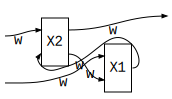

In [3]:
show_diagram(SaltTanks)

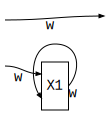

In [4]:
# we can replace x2 with wires that just pass through
Pass = WiringDiagram([:w,:w],[:w,:w])
add_wires!(Pass, Pair[
    (input_id(Pass), 1) => (output_id(Pass), 1),
    (input_id(Pass), 2) => (output_id(Pass), 2)])
res = ocompose(SaltTanks,2,Pass); # syntactic composition
show_diagram(res)  

In [5]:
# Model the dynamics of each tank INDIVIDUALLY

# How does the mass of salt change over time?
# x is state, u is input
# normally function of u,x,p,t, but parameters 'p' unused 
# and no dependence on absolute time, so 't' is unused       
dot_t1(u, x, _, _) = [-(3.0/30.0)*x[1]   # drainage is fn of internal state
                      + 1.5*x[1]         # input conc from outside world * flowrate
                      + (1.5/20.0)*x[2]] # concentration of tank 2 * flowrate
t1_dynamics = ContinuousMachine{Float64}(2, # n_inputs
                                         1, # n_states
                                         1, # n_outputs 
                                         dot_t1, # dynamics
                                         u->u) # readout

# Same for t2 
dot_t2(u, x, _, _) = [ -((1.5+2.5)/20.0)*u[1]  + x[1]*1.0 + (x[2]/30.0)*3.0]

t2_dynamics = ContinuousMachine{Float64}(2, 1, 2, dot_t2, u->[u[1],u[1]])

dynam = oapply(SaltTanks, [t1_dynamics,t2_dynamics]);


In [6]:
u0 = [0.0, 0.0] # initial salt levels in tanks
tspan = (0.0, 30.03)
xs = [t -> 3, t -> 1] # input salt, oz/gal 
prob = ODEProblem(dynam, u0, xs, tspan)
sol = solve(prob, FRK65(0))



LoadError: BoundsError: attempt to access 1-element UnitRange{Int64} at index [1:3]

In [7]:
plot(sol, lw=2, bottom_margin=10mm, left_margin=10mm, title = "Salt", 
        label=["Tank1" "Tank2"])
xlabel!("Time")
ylabel!("Salt, kg")


LoadError: UndefVarError: sol not defined